This script is testing the algorithm in pds using boundary values. I can check the behavior of the pressure propagation is correct or not.

In [1]:
import os
os.listdir()

['243_22562_220-pycharm-support-libs',
 'Phase1.npz',
 '._.DS_Store',
 'data',
 'phase3_new.npz',
 'Phase2.npz',
 'pds',
 '.DS_Store',
 'DSS_analyzer_Mariner',
 'Phase3_prev.npz',
 'Phase3.npz']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pds.DSS_analyzer_Mariner import Data1D_GAUGE, Data1D_PumpingCurve
from scipy.interpolate import interp1d

In [5]:
# Specify the datapath
datapath = "./data"

# Pressure gauge data (Only S well)
gauge_data_foler = datapath + "/gauge_data_swell"

In [6]:
# Load the pressure gauge data. Most close to the first stage is gauge 6. For the stage 8 I need to use gauge 7.
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge6_data_swell.npz")
gauge_dataframe_next = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge7_data_swell.npz")

# Load the pumping curve data (stage7; stage8)
pumping_curve_filepath = datapath + f"/pumping_curve/pumping_curve_stage7.npz"
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [7]:
stage7_start_time = pumping_curve_dataframe.get_start_time()
stage7_end_time = pumping_curve_dataframe.get_end_time()

In [8]:
pumping_curve_filepath_next = datapath + f"/pumping_curve/pumping_curve_stage8.npz"
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath_next)

In [9]:
stage8_start_time = pumping_curve_dataframe_next.get_start_time()
stage8_end_time = pumping_curve_dataframe_next.get_end_time()

In [10]:
# Crop the pressure gauge data
gauge_dataframe.crop(stage7_start_time, stage8_end_time)

In [11]:
gauge_md_idx = np.array([265, 520,  789, 1043, 1312, 1567])
frac_hit_idx = np.array([589, 830])

In [12]:
# Simulator parameters
nx = 5000
# nx = 1800
total_time = 13000
d = 140 * np.ones(nx)
dx = 1
x = np.arange(0, nx*dx, dx)
x = x - nx * dx / 2 # make the center of the domain as 0
t = list([0]) # store the time points
dt = 0
dt_init = 10.0

In [13]:
# Pre-processing the idx of pg and frac hit
# Update the idx of pg and frac hit, make the first frac hit -> x=0
gauge_md_idx = gauge_md_idx - frac_hit_idx[0] + nx // 2
frac_hit_idx = frac_hit_idx - frac_hit_idx[0] + nx // 2

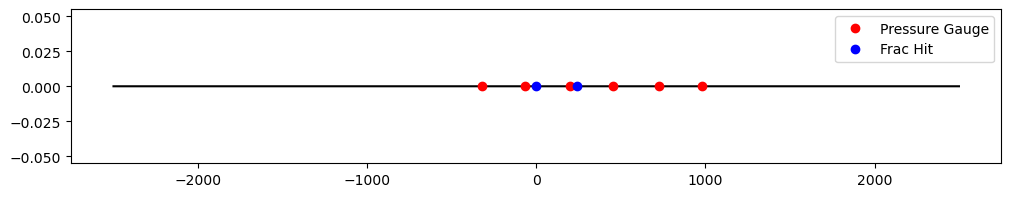

In [14]:
# Plot the location of the pressure gauge and frac hit
plt.figure(figsize=(12, 2))
plt.plot(x, np.zeros(nx), 'k')
plt.plot(x[gauge_md_idx], np.zeros(gauge_md_idx.size), 'ro', label='Pressure Gauge')
plt.plot(x[frac_hit_idx], np.zeros(frac_hit_idx.size), 'bo', label='Frac Hit')
plt.legend()
plt.show()

# Phase 1
In this script, I'll investigate the possibility packing the code into a module.

Develop the code on **haynesville** then call the module here.

In [15]:
from pds.core import pds

In [16]:
pds_frame_phase1 = pds.PDS1D_SingleSource()

In [17]:
# Initialize the simulator
pds_frame_phase1.set_mesh(x)
pds_frame_phase1.set_diffusivity(d)
pds_frame_phase1.set_bcs('Neumann', 'Neumann')
pds_frame_phase1.set_t0(0) # Phase 1 starts at 0
pds_frame_phase1.set_sourceidx(frac_hit_idx[0]) # The source is at the first frac hit

In [18]:
# Process the pressure gauge data to get the source term
phase_1_pg_dataframe = gauge_dataframe.copy()
phase_1_pg_dataframe.crop(stage7_start_time, stage7_end_time)

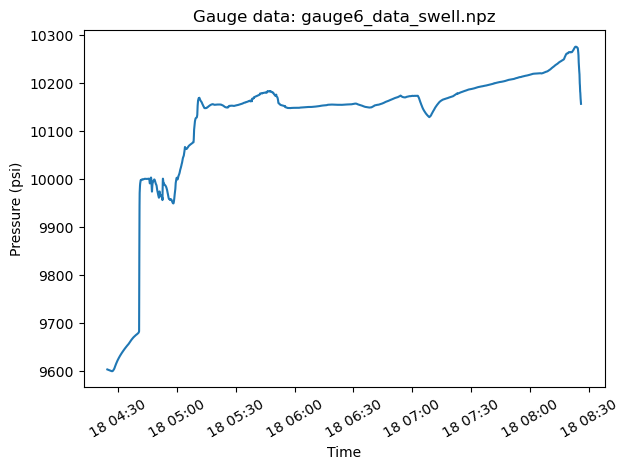

In [19]:
# QC the pressure gauge data
phase_1_pg_dataframe.plot_simple()

In [66]:
pds_frame_phase1.set_source(phase_1_pg_dataframe)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.


In [67]:
# Set the initial condition
u_initial = np.zeros(nx)
u_initial += phase_1_pg_dataframe.data[0]
pds_frame_phase1.set_initial(u_initial)

In [68]:
pds_frame_phase1.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Time array generated using the source term.
Time: 2 Source term: 9604.148
Time: 32 Source term: 9604.07056412729
Time: 62 Source term: 9603.273238642298
Time: 92 Source term: 9602.47516989796
Time: 122 Source term: 9601.682737190813
Time: 152 Source term: 9600.86372284264
Time: 182 Source term: 9600.477121347203
Time: 212 Source term: 9602.09012320917
Time: 242 Source term: 9605.704453693117
Time: 272 Source term: 9611.268763054188
Time: 302 Source term: 9616.494262443439
Time: 332 Source term: 9621.314572556763
Time: 362 Source term: 9625.443425714788
Time: 392 Source term: 9629.296163234554
Time: 422 Source term: 9632.833562058528
Time: 452 Source term: 9636.232628516005
Time: 482 Source term: 9639.377741415557
Time: 512 Source term: 9642.409783458646
Time: 542 Source term: 9645.273221063608
Time: 572 Source term: 9648.107563106796
Time: 602 Source term: 9650.693380610828
Time: 632 Source term: 9653.28130726257
Time: 662 Source term: 9655.705106
Time: 692 Source term: 9658.1780606060

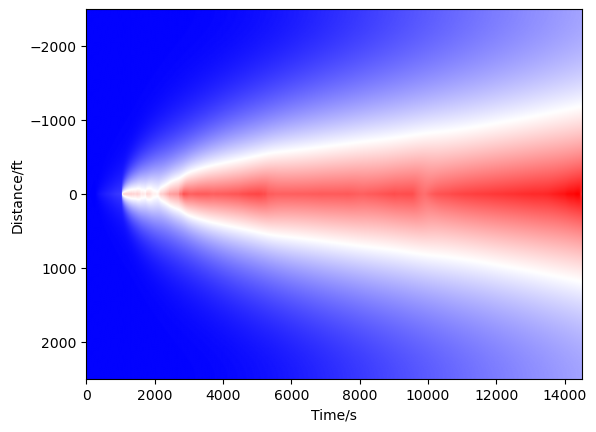

In [79]:
# show the solution
pds_frame_phase1.plot_solution()

# Phase 2

After the first phase:
- Keep the pressure gauge data
- Keep the diffusivity

In [113]:
# Calculate the total_time
total_time = stage8_start_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [114]:
# Initialize the simulator: Phase 2
pds_frame_phase2 = pds.PDS1D_SingleSource()
pds_frame_phase2.set_mesh(x)
pds_frame_phase2.set_diffusivity(d)
pds_frame_phase2.set_bcs('Neumann', 'Neumann')
pds_frame_phase2.set_t0(pds_frame_phase1.taxis[-1]) # Phase 2 starts after phase 1
pds_frame_phase2.set_sourceidx(frac_hit_idx[0]) # The source is at the first frac hit

In [115]:
# Process the pressure gauge data to get the source term
phase_2_pg_dataframe = gauge_dataframe.copy()
phase_2_pg_dataframe.crop(stage7_end_time, stage8_start_time)

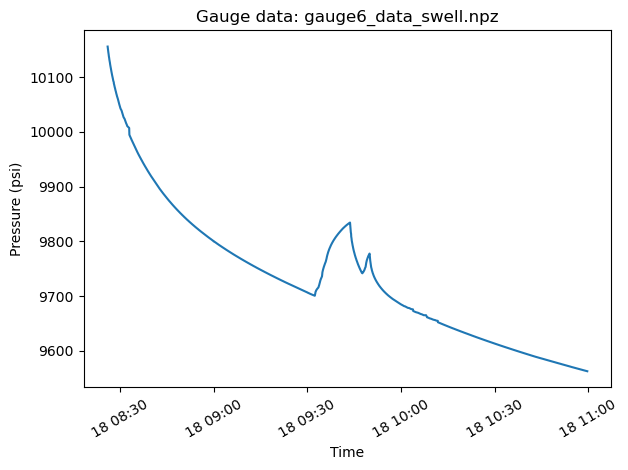

In [116]:
# QC the pressure gauge data
phase_2_pg_dataframe.plot_simple()

In [117]:
# Set the source term
pds_frame_phase2.set_source(phase_2_pg_dataframe)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.


In [118]:
# Set the initial condition
u_initial = pds_frame_phase1.snapshot[-1]
pds_frame_phase2.set_initial(u_initial)

In [ ]:
pds_frame_phase2.solve(optimizer= True,
                       dt_init = 2,
                       t_total = total_time, # Phase 2 ends at the start of stage 8
                       print_progress=True,
                        max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2) # optional parameters

Time array generated using t_total.
Time: 14524 Source term: 10156.084
Time: 14527.354675046096 Source term: 10154.145334322453
Time: 14535.056448232812 Source term: 10151.246661278727
Time: 14552.378479468407 Source term: 10146.163369540107
Time: 14582.378479468407 Source term: 10134.283990203416
Time: 14612.378479468407 Source term: 10116.83086847015
Time: 14642.378479468407 Source term: 10101.81669923289
Time: 14672.378479468407 Source term: 10088.556356521443
Time: 14702.378479468407 Source term: 10076.465654042055
Time: 14732.378479468407 Source term: 10065.364876233609
Time: 14762.378479468407 Source term: 10055.13554025103
Time: 14792.378479468407 Source term: 10045.21382325798
Time: 14822.378479468407 Source term: 10038.240231385766
Time: 14852.378479468407 Source term: 10028.872581346432
Time: 14882.378479468407 Source term: 10022.726526216848
Time: 14912.378479468407 Source term: 10015.009491974315
Time: 14942.378479468407 Source term: 10009.556406978845
Time: 14972.378479468

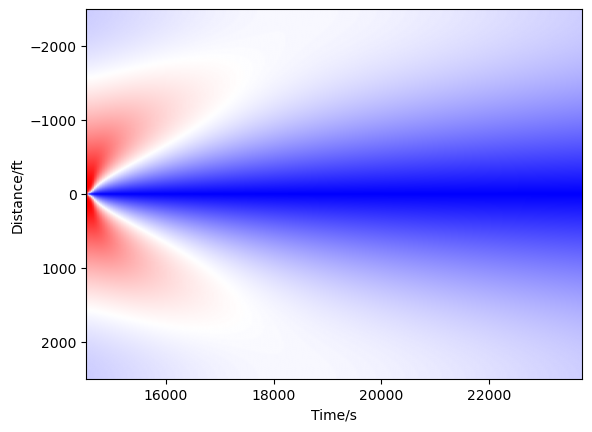

In [120]:
# show the solution
pds_frame_phase2.plot_solution()

# Phase 3 / test

After the second phase:
- Release the pressure gauge data
- Change the diffusivity at first frac hit
- Use next pressure gauge data

In [93]:
# Change diffusivity ratio
diffusivity_change_ratio = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001]) # add more instances compared to 071

In [90]:
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [91]:
# Initialize the simulator: Phase 3
pds_frame_phase3 = pds.PDS1D_SingleSource()
pds_frame_phase3.set_mesh(x)
pds_frame_phase3.set_bcs('Neumann', 'Neumann')
pds_frame_phase3.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2
pds_frame_phase3.set_sourceidx(frac_hit_idx[1]) # The source is at the second frac hit

In [95]:
# Change the diffusivity at the first frac hit
d[frac_hit_idx[0]] = diffusivity_change_ratio[-2] * d[frac_hit_idx[0]]
pds_frame_phase3.set_diffusivity(d)

In [96]:
# Process the pressure gauge data to get the source term
phase_3_pg_dataframe = gauge_dataframe_next.copy()
phase_3_pg_dataframe.crop(stage8_start_time, stage8_end_time)

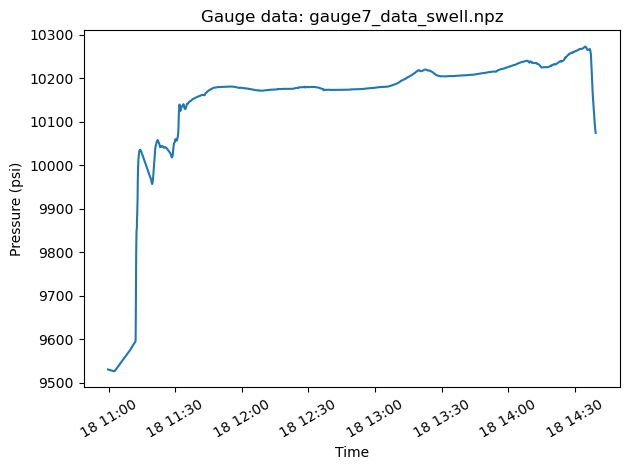

In [97]:
# QC the pressure gauge data
phase_3_pg_dataframe.plot_simple()

In [98]:
# Set the source term
pds_frame_phase3.set_source(phase_3_pg_dataframe)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.


In [99]:
# Set the initial condition
u_initial = pds_frame_phase2.snapshot[-1]
pds_frame_phase3.set_initial(u_initial)

In [100]:
pds_frame_phase3.solve(optimizer= True,
                       dt_init = 2,
                       t_total = total_time, # Phase 3 ends at the end of stage 8
                       print_progress=True,
                        max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2) # optional parameters

Time array generated using t_total.
Time: 23734.378479468407 Source term: 10074.16
Time: 23738.11064836754 Source term: 10074.16
Time: 23747.33343877886 Source term: 10074.16
Time: 23769.411190246577 Source term: 10074.16
Time: 23799.411190246577 Source term: 10074.16
Time: 23829.411190246577 Source term: 10074.16
Time: 23859.411190246577 Source term: 10074.16
Time: 23889.411190246577 Source term: 10074.16
Time: 23919.411190246577 Source term: 10074.16
Time: 23949.411190246577 Source term: 10074.16
Time: 23979.411190246577 Source term: 10074.16
Time: 24009.411190246577 Source term: 10074.16
Time: 24039.411190246577 Source term: 10074.16
Time: 24069.411190246577 Source term: 10074.16
Time: 24099.411190246577 Source term: 10074.16
Time: 24129.411190246577 Source term: 10074.16
Time: 24159.411190246577 Source term: 10074.16
Time: 24189.411190246577 Source term: 10074.16
Time: 24219.411190246577 Source term: 10074.16
Time: 24249.411190246577 Source term: 10074.16
Time: 24279.411190246577 S

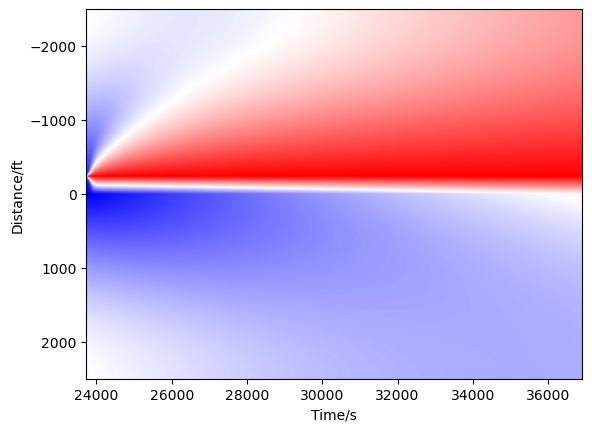

In [121]:
# show the solution
pds_frame_phase3.plot_solution()

# Phase 3 / Full

Test the diffusivity change at the first frac hit. Use a list of diffusivity change ratio.

In [151]:
total_time = stage8_end_time - stage7_start_time
# convert the datetime to seconds
total_time = total_time.total_seconds()

In [152]:
# Initialize the simulator: Phase 3
pds_frame_phase3_all = []

In [ ]:
for iter in diffusivity_change_ratio:
    pds_frame_phase3_iter = pds.PDS1D_SingleSource()
    pds_frame_phase3_iter.set_mesh(x)
    pds_frame_phase3_iter.set_bcs('Neumann', 'Neumann')
    pds_frame_phase3_iter.set_t0(pds_frame_phase2.taxis[-1]) # Phase 3 starts after phase 2
    pds_frame_phase3_iter.set_sourceidx(frac_hit_idx[1]) # The source is at the second frac hit
    # Change the diffusivity at the first frac hit
    # First, set the diffusivity
    d = 140 * np.ones(nx)
    d[frac_hit_idx[0]] = iter * d[frac_hit_idx[0]]
    pds_frame_phase3_iter.set_diffusivity(d)
    # Use the next pressure gauge data which I have already loaded
    pds_frame_phase3_iter.set_source(phase_3_pg_dataframe)
    # Set the initial condition
    u_initial = pds_frame_phase2.snapshot[-1]
    pds_frame_phase3_iter.set_initial(u_initial)
    # Solve
    pds_frame_phase3_iter.solve(optimizer= True,
                       dt_init = 2,
                       t_total = total_time, # Phase 3 ends at the end of stage 8
                       print_progress=True,
                        max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2) # optional parameters
    pds_frame_phase3_all.append(pds_frame_phase3_iter)

Message from pds: Source set done.
Also, just a reminder: please make sure the data is cropped properly.
Time array generated using t_total.
Time: 23734.378479468407 Source term: 9530.631


# Post-processing

In [133]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3.snapshot], axis=0)

In [134]:
np.shape(snapshot_result_all)

(1240, 5000)

In [135]:
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3.taxis], axis=0)

In [136]:
np.shape(taxis_result_all)

(1240,)

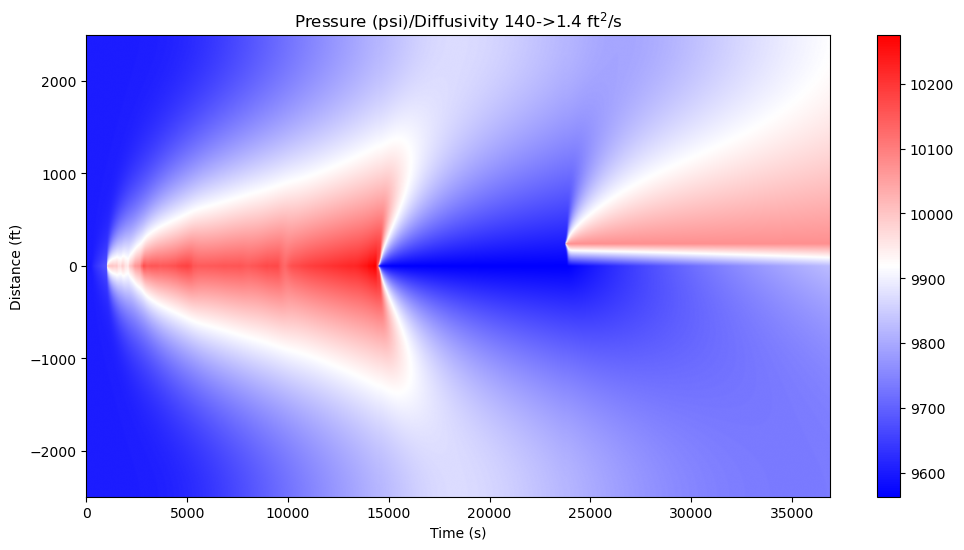

In [141]:
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr', extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]])
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Pressure (psi)/Diffusivity 140->1.4 ft$^2$/s')
plt.gca().invert_yaxis()
plt.show()

In [143]:
# Get the value of the pressure at the pressure gauge location
pg_value = []
for pg in gauge_md_idx:
    pg_value.append(snapshot_result_all[:, pg])

In [144]:
pg_value = np.array(pg_value)
np.shape(pg_value)

(6, 1240)

In [147]:
# Load the real pressure gauge data
real_pg_data = []
real_pg_data_taxis = []
gauge_num = [5, 6, 7, 8, 9, 10]
for num in gauge_num:
    gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_foler + f"/gauge{num}_data_swell.npz")
    gauge_dataframe.crop(stage7_start_time, stage8_end_time)
    time_sec = gauge_dataframe.calculate_time() * 3600
    real_pg_data.append(gauge_dataframe.data)
    real_pg_data_taxis.append(time_sec)

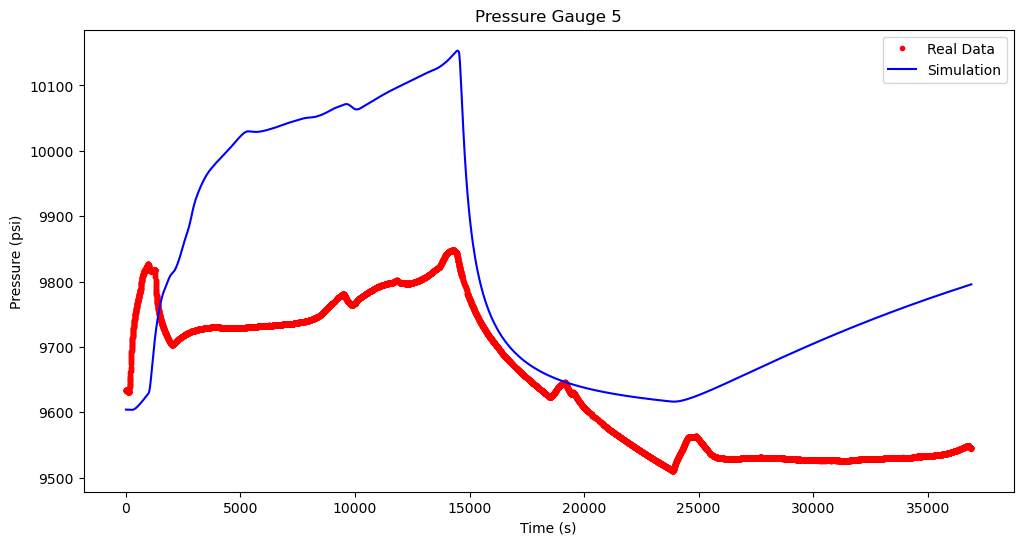

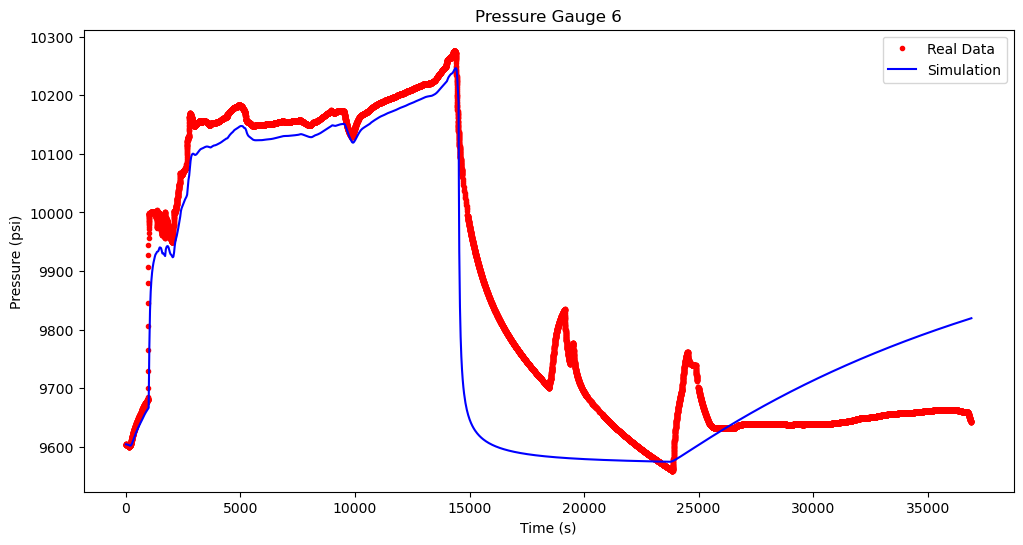

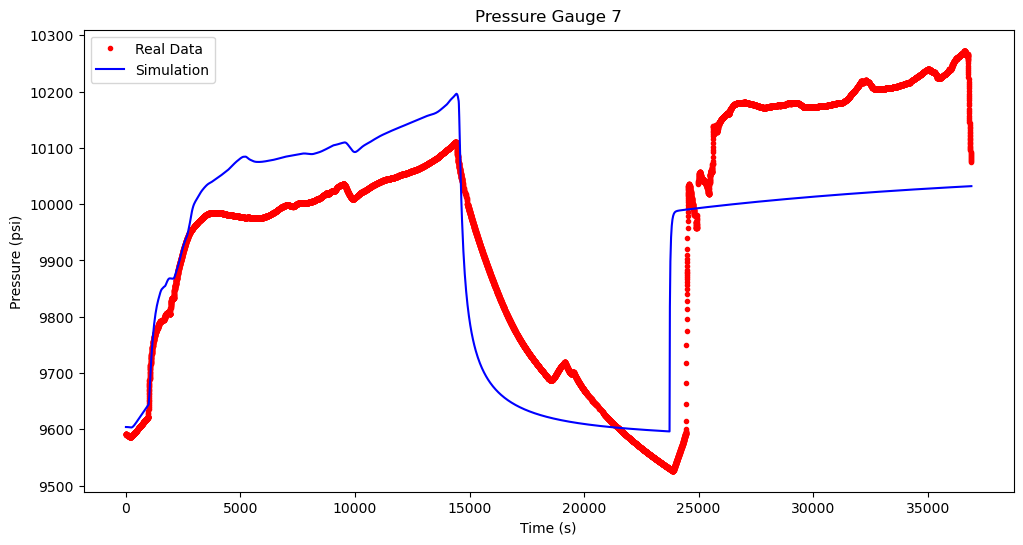

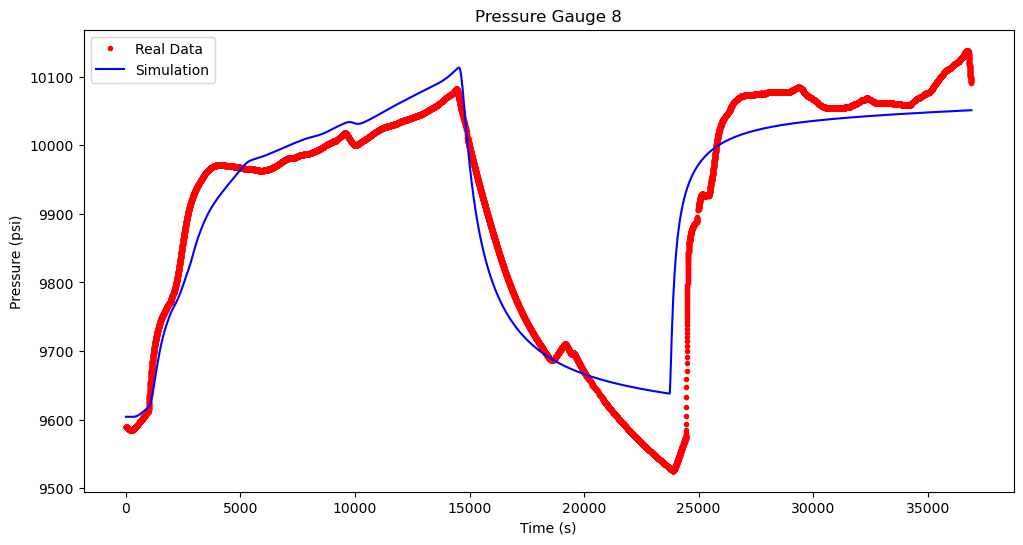

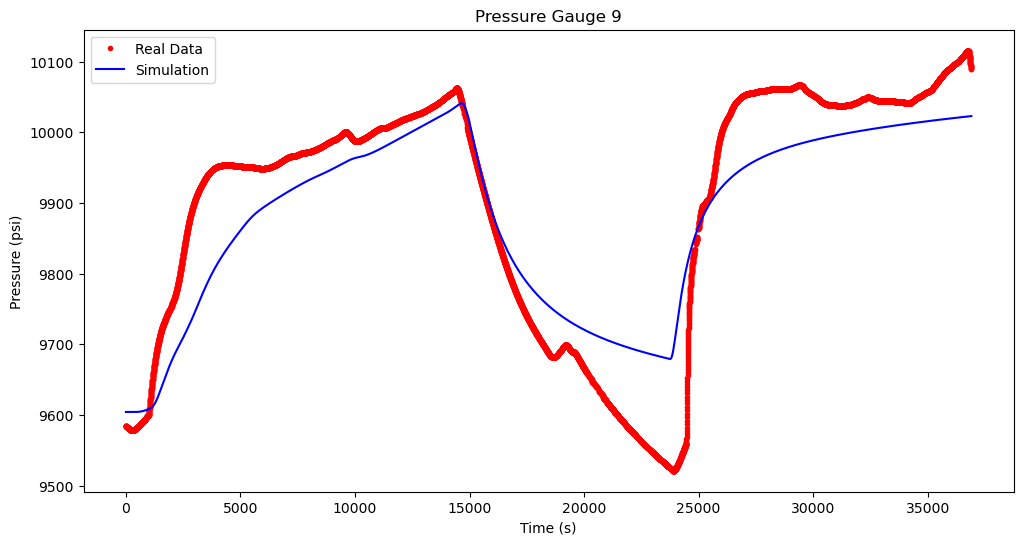

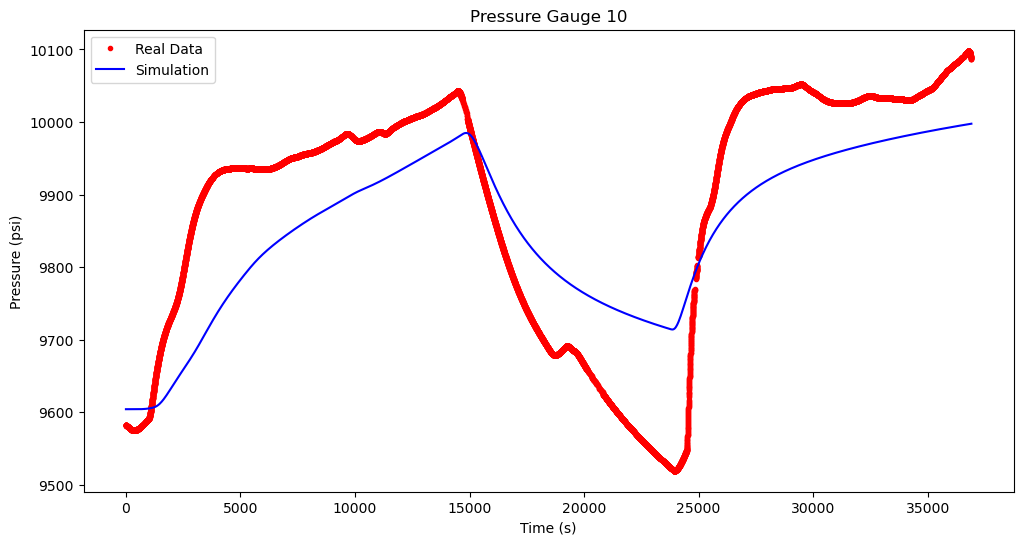

In [150]:
# Compare the simulation and real data
for i in range(len(gauge_num)):
    plt.figure(figsize=(12, 6))
    plt.plot(real_pg_data_taxis[i], real_pg_data[i], 'ro', label='Real Data', markersize=3)
    plt.plot(taxis_result_all, pg_value[i], 'b-', label='Simulation')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title(f'Pressure Gauge {gauge_num[i]}')
    plt.show()

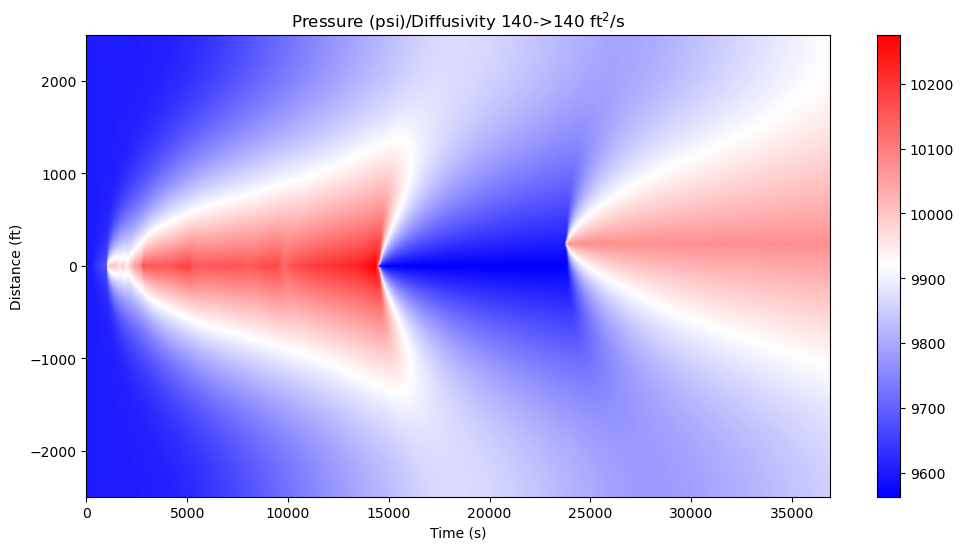

In [159]:
# Combine the results -> snapshot
snapshot_result_all = np.concatenate([pds_frame_phase1.snapshot, pds_frame_phase2.snapshot], axis=0)
snapshot_result_all = np.concatenate([snapshot_result_all, pds_frame_phase3_all[0].snapshot], axis=0)
np.shape(snapshot_result_all)
# Combine the results -> taxis
taxis_result_all = np.concatenate([pds_frame_phase1.taxis, pds_frame_phase2.taxis], axis=0)
taxis_result_all = np.concatenate([taxis_result_all, pds_frame_phase3_all[0].taxis], axis=0)
np.shape(taxis_result_all)
# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(snapshot_result_all.T, aspect='auto', cmap='bwr',
           extent=[taxis_result_all[0], taxis_result_all[-1], x[-1], x[0]])
plt.colorbar()
plt.ylabel('Distance (ft)')
plt.xlabel('Time (s)')
plt.title('Pressure (psi)/Diffusivity 140->140 ft$^2$/s')
plt.gca().invert_yaxis()
plt.show()

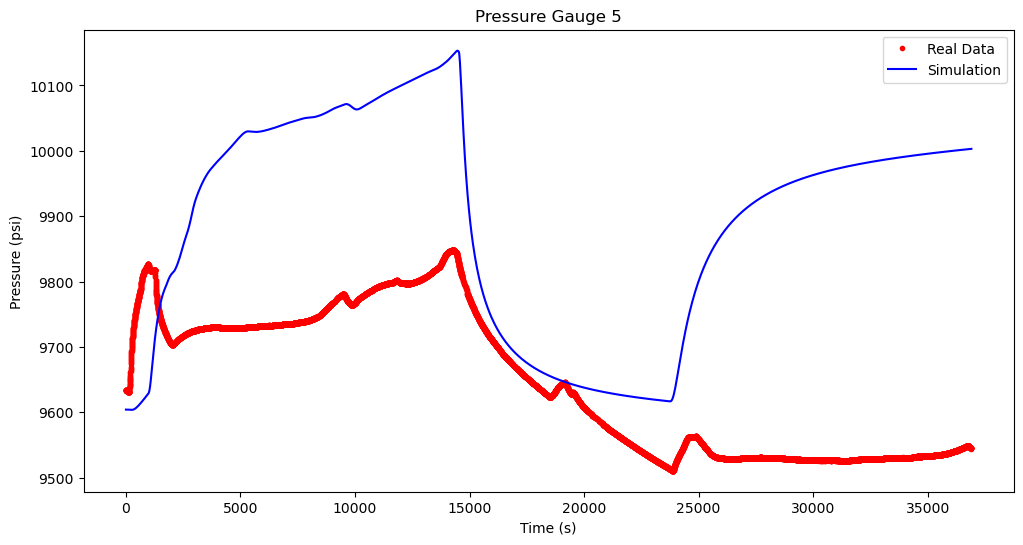

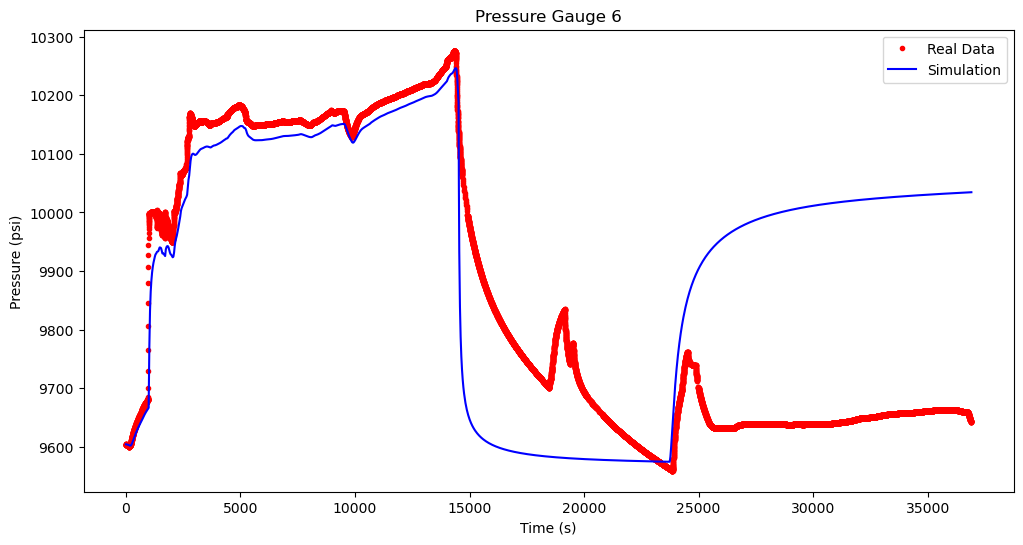

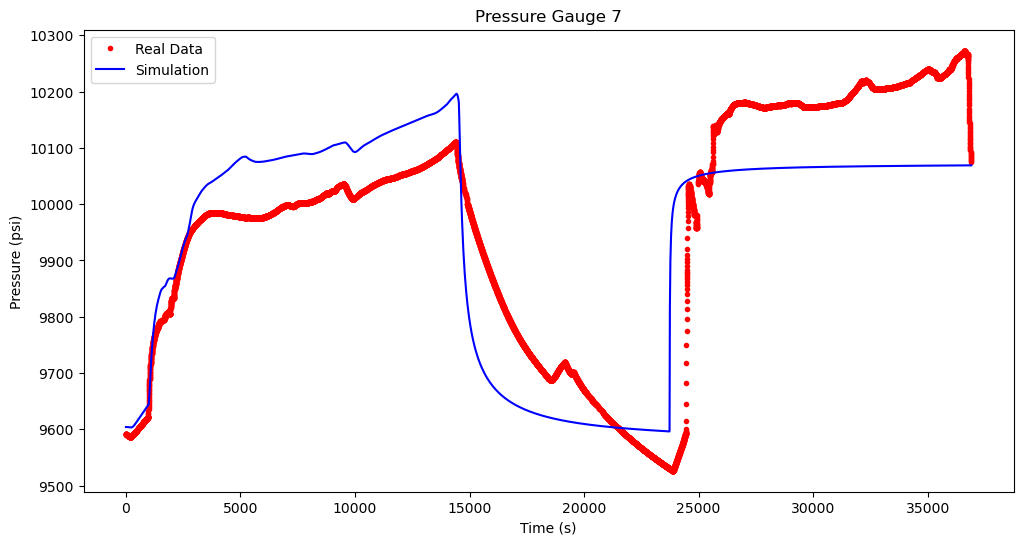

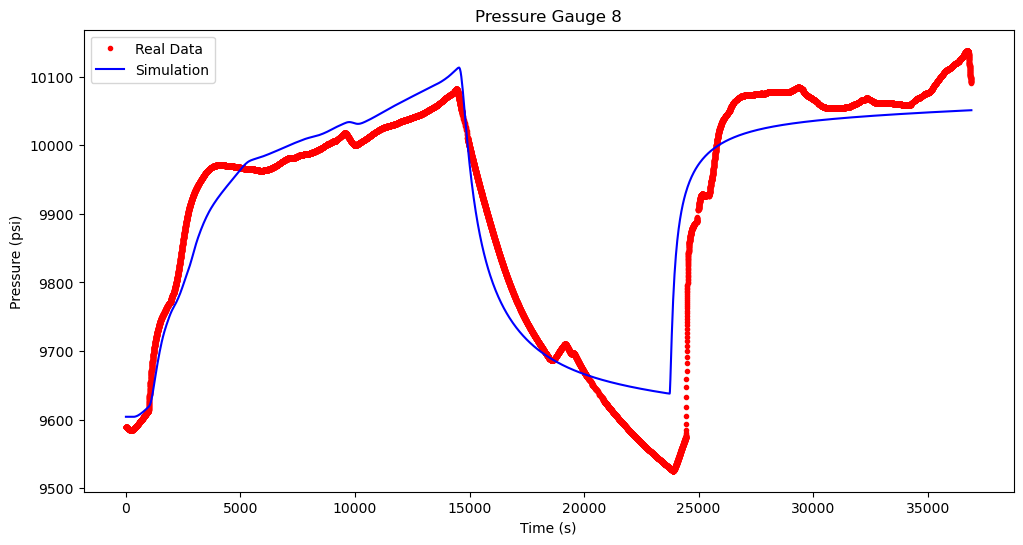

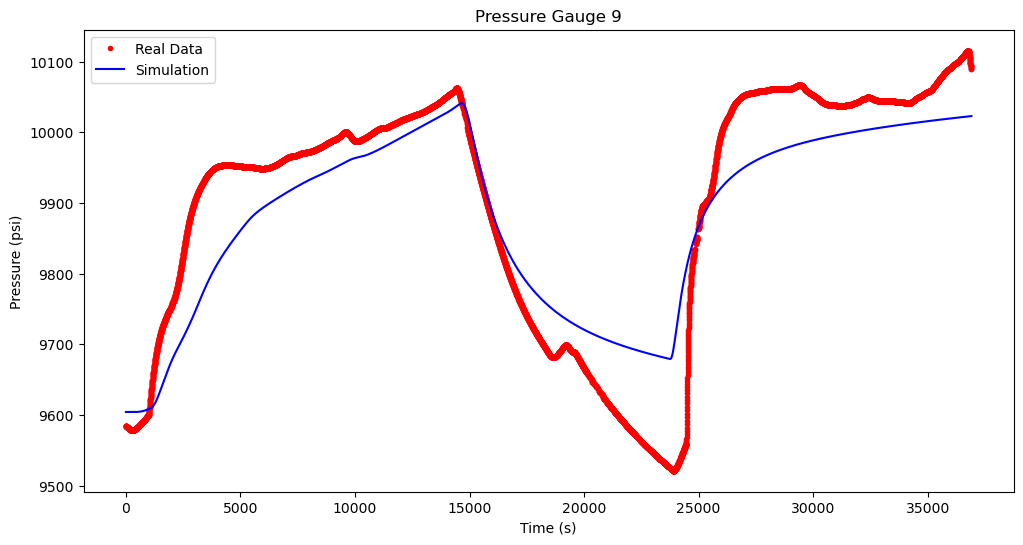

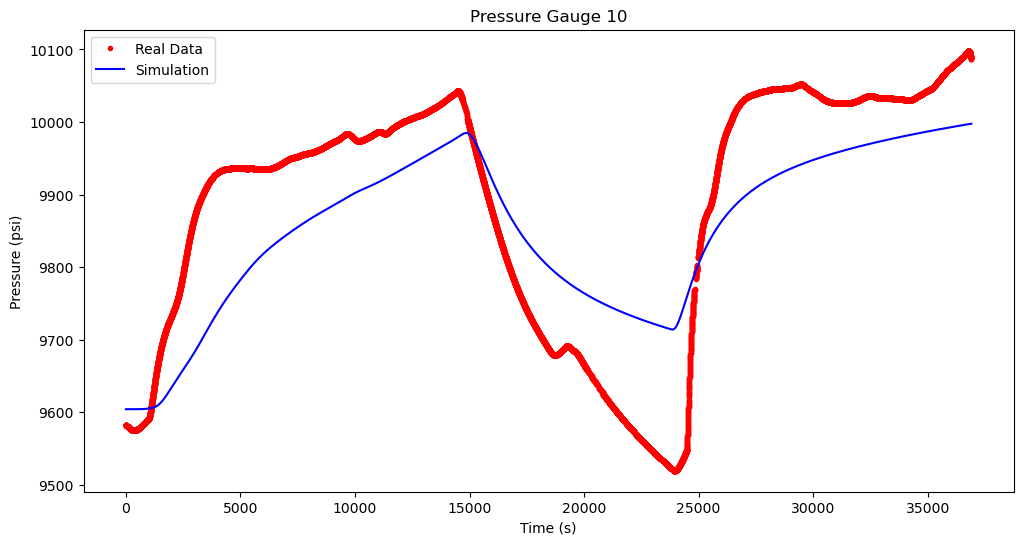

In [157]:
# Get the value of the pressure at the pressure gauge location
pg_value = []
for pg in gauge_md_idx:
    pg_value.append(snapshot_result_all[:, pg])
pg_value = np.array(pg_value)
np.shape(pg_value)

# Compare the simulation and real data
for i in range(len(gauge_num)):
    plt.figure(figsize=(12, 6))
    plt.plot(real_pg_data_taxis[i], real_pg_data[i], 'ro', label='Real Data', markersize=3)
    plt.plot(taxis_result_all, pg_value[i], 'b-', label='Simulation')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title(f'Pressure Gauge {gauge_num[i]}')
    plt.show()